### Obtaining Testing and Training data

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd


np.random.seed(42)
tf.random.set_seed(42)
df = pd.read_csv("../train.csv")
df = df.drop("qid", axis=1)

In [2]:
df.head()

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


## Train and Validation split

In [4]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, train_size=0.1, test_size=0.00075, stratify=df.target.values)

X_test = pd.read_csv("../test.csv")

x_train, y_train = train_df["question_text"].values, train_df["target"].values
x_val, y_val = val_df["question_text"].values, val_df["target"].values
x_test = X_test["question_text"]

## Vectorize Sentences

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
train_x_vec = vectorizer.fit_transform(x_train)
val_x_vec = vectorizer.transform(x_val)
test_x_vec = vectorizer.transform(x_test)

print(train_x_vec.shape)
print(val_x_vec.shape)
print(test_x_vec.shape)

(130612, 10000)
(980, 10000)
(375806, 10000)


### CNN Model Definition

In [6]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(10000,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [7]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,281 (9.89 MB)

 Trainable params: 2,593,281 (9.89 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [8]:
history = model.fit(train_x_vec, y_train, validation_data=(val_x_vec, y_val), epochs=5, batch_size=16)

Epoch 1/5
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 69s 8ms/step - accuracy: 0.9416 - loss: 0.1731 - val_accuracy: 0.9480 - val_loss: 0.1516
Epoch 2/5
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - accuracy: 0.9510 - loss: 0.1231 - val_accuracy: 0.9510 - val_loss: 0.1629
Epoch 3/5
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 69s 8ms/step - accuracy: 0.9624 - loss: 0.0981 - val_accuracy: 0.9490 - val_loss: 0.1944
Epoch 4/5
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 69s 9ms/step - accuracy: 0.9753 - loss: 0.0667 - val_accuracy: 0.9418 - val_loss: 0.2474
Epoch 5/5
8164/8164 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - accuracy: 0.9846 - loss: 0.0433 - val_accuracy: 0.9347 - val_loss: 0.3546


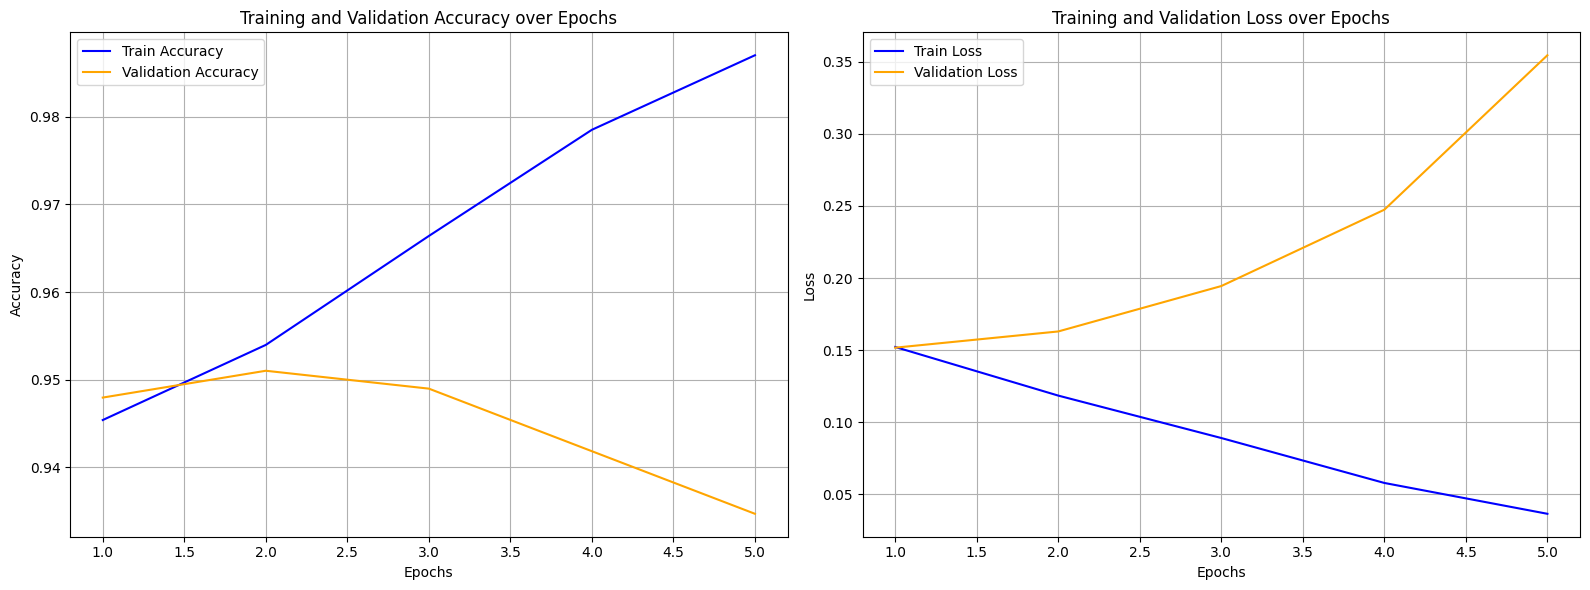

In [9]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot training and validation accuracy
ax1.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy', color='blue')
ax1.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='orange')
ax1.set_title('Training and Validation Accuracy over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot training and validation loss
ax2.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', color='blue')
ax2.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
ax2.set_title('Training and Validation Loss over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

## Prediction and Test Accuracy

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       919
           1       0.47      0.41      0.44        61

    accuracy                           0.93       980
   macro avg       0.72      0.69      0.70       980
weighted avg       0.93      0.93      0.93       980



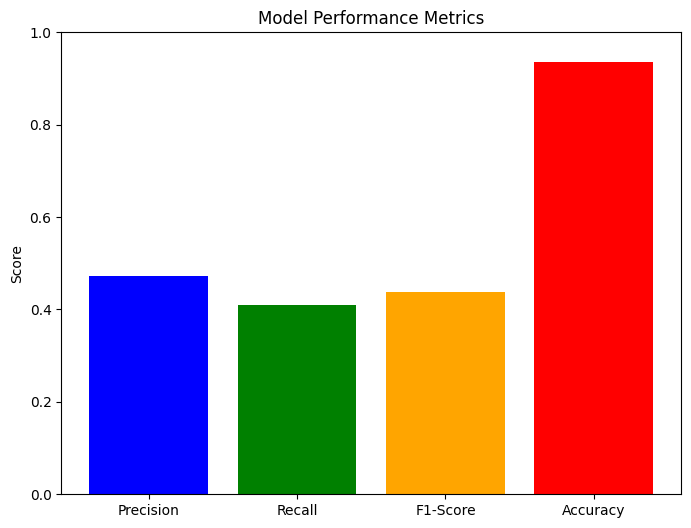

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Predictions
y_pred_probs = model.predict(val_x_vec)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Print Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred))

# Create a bar chart for precision, recall, F1-score, and accuracy
metrics = [precision, recall, f1, accuracy]
metric_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(metric_names, metrics, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()

## Confusion Matrix

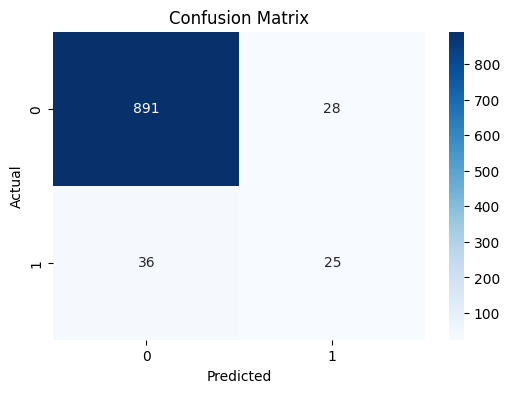

In [11]:
import seaborn as sns
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## ROC Curve

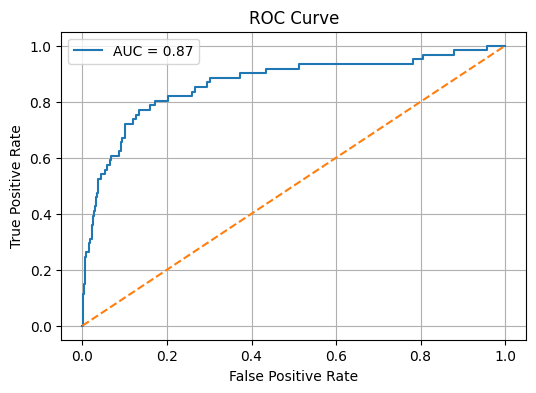

In [12]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## Submission

In [13]:
def submit():
    submission = X_test[['qid']].copy() 
    prediction = model.predict(test_x_vec)
    pred = (prediction > 0.5).astype(int)
    submission['prediction'] = pred
    submission.to_csv('submission.csv', index=False)
    return submission

submit()

11744/11744 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step


,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0
